# Trajectory inference for hematopoiesis in mouse using simulated federated PCA

This code has been adapted from a scanpy vignette: Reconstructing myeloid and erythroid differentiation for data of [Paul et al. (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

In [2]:
#sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
#results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  
sc.settings.figdir='/home/anne/Documents/featurecloud/pca/horizontal-pca/figures/single-cell'# low dpi (dots per inch) yields small inline figures

In [3]:
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


In [4]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

Let us work with a higher precision than the default 'float32' to ensure _exactly_ the same results across different computational platforms.

In [5]:
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it

## Preprocessing and Visualization

Apply a simple [preprocessing recipe](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.pp.recipe_zheng17.html).

In [6]:
sc.pp.recipe_zheng17(adata)

In [7]:
sc.tl.pca(adata, svd_solver='arpack')

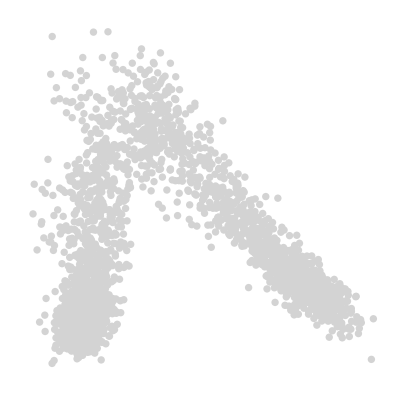

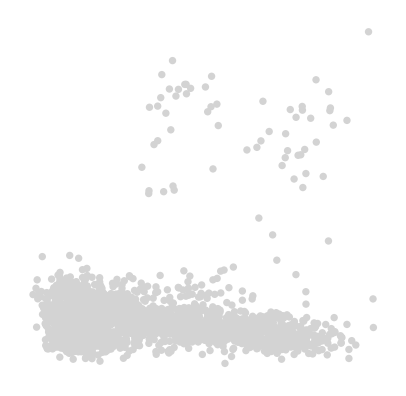

In [8]:
sc.pl.pca(adata, components =['1,2'], save='paga_12_centralised')
sc.pl.pca(adata, components =['2,3'], save='paga_23_centralised')

In [ ]:
basedir = '/home/anne/Documents/manuscripts/horizontal-pca'
pcapath = '/home/anne/Documents/featurecloud/pca/federated_dp_pca'
datapath = '/home/anne/Documents/featurecloud/pca/scanpy/data/filtered_gene_bc_matrices/hg19/'
outdir = '/home/anne/Documents/featurecloud/pca/horizontal-pca/results/single-cell'

In [9]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp
import seaborn as sns
import os.path as op
import os
import scipy.linalg as la
import matplotlib.pyplot as plt
import sys

# Custom code
sys.path.append(pcapath)
from python.PCA.horizontal.horizontal_pca_benchmark import wrapper_k_variation
import python.PCA.shared_functions as sh

import python.PCA.horizontal.horizontal_pca_power_iteration as h
import python.PCA.horizontal.balcan as b
import python.PCA.horizontal.proxy_covariance as proxy
import python.PCA.vertical.simulate_federated_vertically_partionned_pca as vertical
import python.PCA.comparison as co

#### Split the data, simulate federated PCA (using a very high number of PCs, likely not necessary in practice)

In [10]:
data_list, r = sh.partition_data_horizontally(adata.X, splits=5, equal=True, randomize=False)
# simulate federated approximate PCA
k = 50
xx, ee = b.simulate_federated_horizontal_pca(data_list, k)
proj = np.dot(adata.X, xx)


(100, 1000)
(100, 1000)
(100, 1000)
(100, 1000)
(100, 1000)
Intermediate dimensions100
(500, 1000)


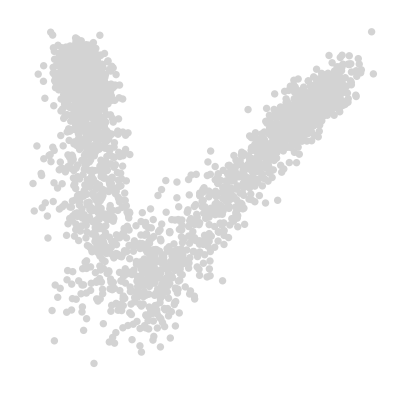

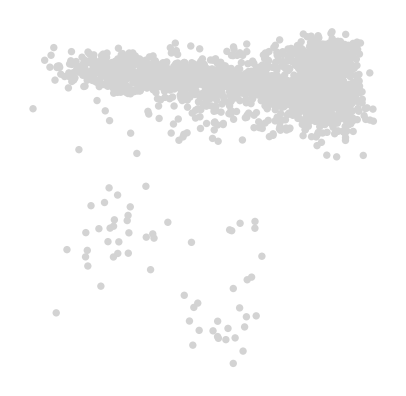

In [11]:
adata.obsm['X_pca_approx'] = proj
adata.varm['PCs_approx'] = xx
sc.pl.embedding(adata, basis = 'X_pca_approx' , components =['1,2'], save='approx_paga_12')
sc.pl.embedding(adata,basis = 'X_pca_approx' , components =['2,3'], save='approx_paga_23')

#### Compute the overlap between the top 20 and lowest 20 loadings

In [12]:
def compare_loadings(x, x0):
    ttl = [] # top ten loading
    tll = [] # ten lowest loadings
    for i in range(x.shape[1]):
        top10 = adata.var.index[np.argsort(x[:,i])[0:20]]
        low10 = adata.var.index[np.argsort(x[:,i])[-21:-1]]
        top10scanpy = adata.var.index[np.argsort(x0[:,i])[0:20]]
        low10scanpy = adata.var.index[np.argsort(x0[:,i])[-21:-1]]
        ttl.append(len(top10.intersection(top10scanpy)))
        tll.append(len(low10.intersection(low10scanpy)))
    return ttl, tll

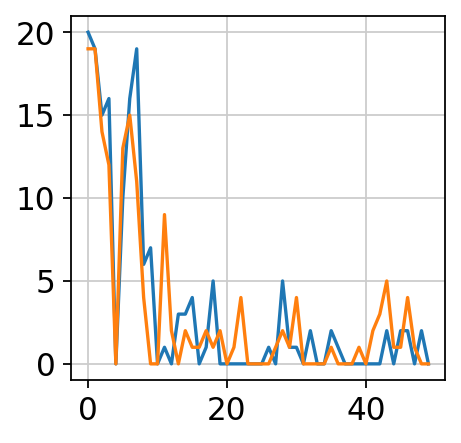

In [13]:
# orthonormalise eigenvectors before use!!!
adata.varm['PCs'],x = la.qr(adata.varm['PCs'], mode='economic')
adata.varm['PCs_approx'],x = la.qr(adata.varm['PCs_approx'], mode='economic')
#adata.varm['PCs'],x = la.qr(adata.varm['PCs'], mode='economic')


ttl, tll = compare_loadings(adata.varm['PCs'],adata.varm['PCs_approx'])
sns.lineplot(x =range(len(ttl)), y = ttl)
sns.lineplot(x =range(len(tll)), y = tll)

pd.DataFrame(ttl).to_csv('/home/anne/Documents/featurecloud/pca/horizontal-pca/results/single-cell/paga_overlap_top.tsv', sep='\t')
pd.DataFrame(tll).to_csv('/home/anne/Documents/featurecloud/pca/horizontal-pca/results/single-cell/paga_overlap_bottom.tsv', sep='\t')
